In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb  9 12:01:18 2020

@author: colin
"""

import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Wordcloud
from wordcloud import WordCloud, STOPWORDS

In [41]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['thank','morning','question', 'go', 'see', 'also'])

# Import Dataset
df = pd.read_csv('transcripts_sent (staples combined).csv')
df.head()

,Unnamed: 0,Sent
0,0,"Thank you, Kate, and good morning, everyone, a..."
1,1,With me to review Kroger’s second quarter 2017...
2,2,"As you know, Kroger has competed in an ever-ch..."
3,3,"Our success over time boils down to one thing,..."
4,4,That focus allows us to deepen our connection ...


In [42]:
# Convert to list
data = df.Sent.values.tolist()

pprint(data[:1])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])


['Thank you, Kate, and good morning, everyone, and thank you for joining us']
[['thank', 'you', 'kate', 'and', 'good', 'morning', 'everyone', 'and', 'thank', 'you', 'for', 'joining', 'us']]


In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

['thank', 'you', 'kate', 'and', 'good_morning_everyone', 'and', 'thank', 'you', 'for', 'joining', 'us']


In [44]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:10])


[['good', 'join'], ['second', 'quarter', 'result', 'executive', 'vice', 'president', 'officer'], ['know', 'compete', 'ever', 'change', 'retail', 'landscape', 'year'], ['success', 'time', 'boil', 'thing', 'relentless', 'focus', 'customer'], ['allow', 'deepen', 'connection', 'customer', 'create'], ['customer', 'remain', 'center'], ['core', 'element', 'customer', 'strategy', 'relevant', 'today', 'first', 'introduce'], ['invest', 'year', 'customer', 'engagement', 'change', 'regularly', 'base', 'customer', 'change', 'need', 'want'], ['show', 'second', 'quarter', 'result', 'return', 'positive', 'identical_supermarket', 'sale', 'growth', 'loyal', 'total', 'household', 'increase'], ['traffic', 'unit', 'movement', 'market', 'share']]


In [26]:
# Generate word cloud to evaluate any additional stopwords to include
# Can skip this cell in subsequent code runs

comment_words = ' '
stopwords = set(STOPWORDS) 
for val in data_lemmatized: 
      
    # typecaste each val to string 
    #val = str(val) 
  
    # split the value 
    #tokens = val.split() 
    for words in val: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1), (1, 1)], [(2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)], [(16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)], [(17, 1), (23, 1), (24, 1), (25, 1), (26, 1)], [(17, 1), (27, 1), (28, 1)], [(17, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1)], [(9, 2), (15, 1), (17, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1)], [(5, 1), (6, 1), (7, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(52, 1), (53, 1), (54, 1), (55, 1), (56, 1)]]


In [46]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.041*"include" + 0.030*"start" + 0.028*"let" + 0.028*"number" + '
  '0.025*"fragrance" + 0.025*"organic" + 0.024*"turn" + 0.020*"thank" + '
  '0.019*"beverage" + 0.018*"build"'),
 (1,
  '0.063*"growth" + 0.059*"business" + 0.058*"continue" + 0.041*"sale" + '
  '0.030*"grow" + 0.028*"strong" + 0.027*"go" + 0.027*"expect" + 0.026*"well" '
  '+ 0.026*"increase"'),
 (2,
  '0.068*"year" + 0.062*"quarter" + 0.052*"think" + 0.026*"high" + '
  '0.025*"really" + 0.022*"launch" + 0.022*"get" + 0.021*"good" + 0.020*"come" '
  '+ 0.019*"result"'),
 (3,
  '0.047*"know" + 0.045*"lot" + 0.043*"thing" + 0.040*"point" + 0.040*"time" + '
  '0.033*"competitive" + 0.031*"term" + 0.029*"right" + 0.029*"third" + '
  '0.024*"give"'),
 (4,
  '0.052*"company" + 0.043*"plan" + 0.043*"call" + 0.039*"second" + '
  '0.036*"level" + 0.034*"fiscal" + 0.021*"improvement" + 0.020*"example" + '
  '0.019*"mention" + 0.017*"makeup"'),
 (5,
  '0.076*"look" + 0.043*"last" + 0.039*"performance" + 0.035*"margin" + '

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.479347704704729

Coherence Score:  0.3153511556920918


In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.433299  0.017365       1        1  22.935602
2      0.044413 -0.406872       2        1  20.539774
7      0.066943  0.184606       3        1  16.255941
6      0.069263  0.048910       4        1   9.330780
5      0.064526  0.036291       5        1   8.325912
0      0.064765  0.039905       6        1   7.643664
3      0.061698  0.037932       7        1   7.518277
4      0.061691  0.041864       8        1   7.450055, topic_info=            Term         Freq        Total Category  logprob  loglift
212        brand  1153.000000  1153.000000  Default  30.0000  30.0000
15          year  1106.000000  1106.000000  Default  29.0000  29.0000
42        growth  1142.000000  1142.000000  Default  28.0000  28.0000
5        quarter  1006.000000  1006.000000  Default  27.0000  27.0000
122     business  1068.000000  1068.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
519    make_sure    54.456100    55.341900   Topic8  -4.6794   2.5808
1051  initiative    53.423782    54.307777   Topic8  -4.6985   2.5805
500     multiple    45.771946    46.658764   Topic8  -4.8531   2.5778
1330      driver    44.927998    45.812798   Topic8  -4.8717   2.5774
1755        hair    48.151619    49.131065   Topic8  -4.8024   2.5768

[271 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
457       4  0.983934         able
868       2  0.991285  acquisition
2094      5  0.988414       action
1102      3  0.995412     activity
478       1  0.998132     actually
...     ...       ...          ...
63        1  0.999152         well
90        4  0.998334         work
709       7  0.987763        world
389       2  0.997093        would
15        2  0.999258         year

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 8, 7, 6, 1, 4, 5])

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')

        
        
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=6)



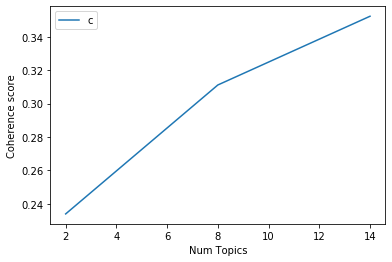

In [49]:
# Show graph
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()